In [1]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [2]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(ComplexHeatmap)
library(gplots)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




## Save Directories for Figs + Tables

In [3]:
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

## Load Yadav data

In [4]:
yadav <- readRDS('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/HumanSpinalCord_seurat_obj.rds')
DefaultAssay(yadav) <- "RNA"

In [5]:
# Normalize the data
yadav <- NormalizeData(yadav, normalization.method = "LogNormalize", scale.factor = 10000)

In [6]:
yadav_neurons <- subset(yadav, top_level_annotation == "Neurons")

In [7]:
yadav_neurons$motor_neuron <- ifelse(yadav_neurons$subtype_annotation == "Motoneurons", yes = "Motor Neurons", no = "Other Neurons")

## Violin plots - genes and UMIs per nucleus

### Normalized nFeature_RNA

In [8]:
median_nFeature <- filter(yadav_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$nFeature_RNA)}

In [9]:
median_nFeature

[1] 5249

In [10]:
filter(yadav_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$nFeature_RNA)}

[1] 936

In [11]:
yadav_neurons$norm_nFeature_RNA = yadav_neurons$nFeature_RNA/median_nFeature

### Figure S1S (right)

In [12]:
yadav_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')

In [13]:
yadav_neurons$label <- ifelse(yadav_neurons$motor_neuron == "Motor Neurons", yes = "MNs", no = "Other")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



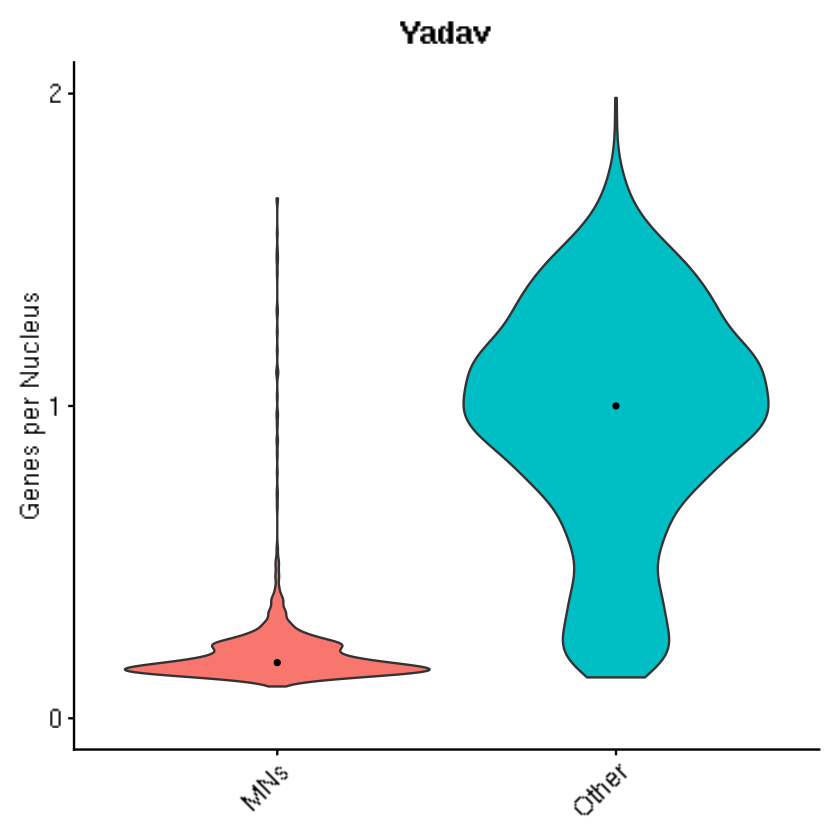

In [14]:
yadav_norm_nFeature_RNA <- VlnPlot(yadav_neurons, group.by = "label", features = "norm_nFeature_RNA", pt.size = 0) + 
  labs(title = "Yadav", y = "Genes per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,2), breaks=c(0,1,2)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())
 
yadav_norm_nFeature_RNA

In [15]:
ggsave(yadav_norm_nFeature_RNA, filename = paste(fig_dir, 'Reviews/yadav_norm_nFeature_RNA.svg', sep='/'), device='svg', width = 1.9, height = 3.4, units = "in")

### Normalized nCount_RNA

In [16]:
median_nCount <- filter(yadav_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$nCount_RNA)}

In [17]:
median_nCount

[1] 16809.5

In [18]:
filter(yadav_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$nCount_RNA)}

[1] 1432

In [19]:
yadav_neurons$norm_nCount_RNA = yadav_neurons$nCount_RNA/median_nCount

### Figure S1T (right)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



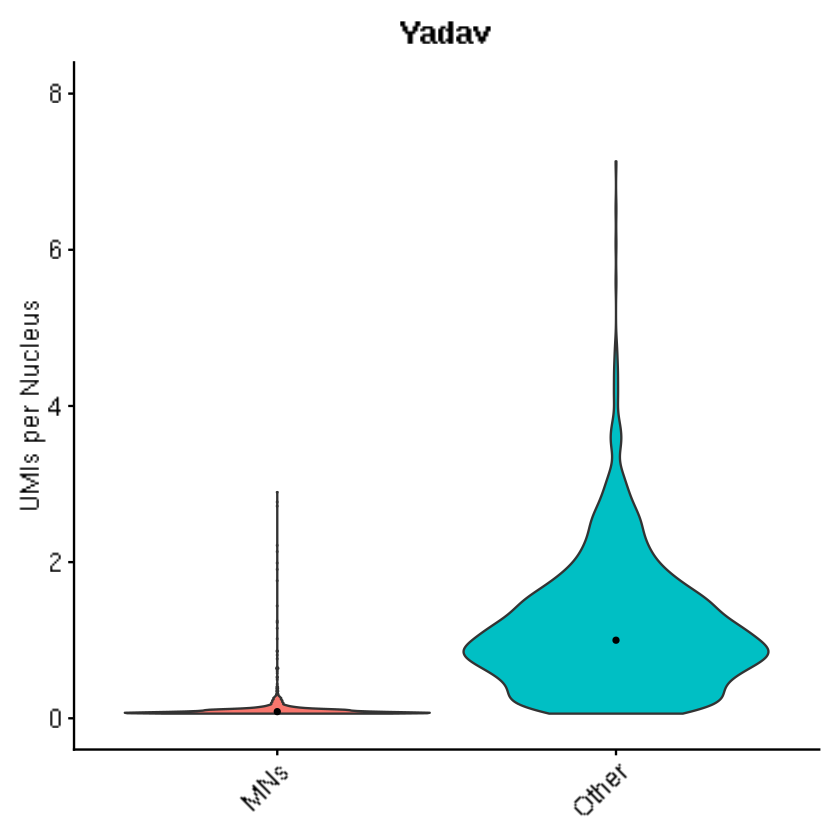

In [20]:
yadav_norm_nCount_RNA <- VlnPlot(yadav_neurons, group.by = "label", features = "norm_nCount_RNA", pt.size = 0) + 
  labs(title = "Yadav", y = "UMIs per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
)  + scale_y_continuous(limits = c(0,8)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())

yadav_norm_nCount_RNA

In [21]:
ggsave(yadav_norm_nCount_RNA, filename = paste(fig_dir, 'Reviews/yadav_norm_nCount_RNA.svg', sep='/'), device='svg', width = 1.9, height = 3.4, units = "in")

### Subset motor neurons

In [22]:
yadav_mns <- subset(yadav_neurons, motor_neuron == "Motor Neurons")

### Save objects

In [23]:
saveRDS(yadav, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav.rds')
saveRDS(yadav_neurons, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')
saveRDS(yadav_mns, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_mns.rds')

### Yadav motor neuron markers

In [24]:
yadav_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')

In [25]:
Idents(yadav_neurons) <- yadav_neurons$motor_neuron
yadav_neurons_markers <-  FindMarkers(yadav_neurons, ident.1 = "Motor Neurons", ident.2="Other Neurons", logfc.threshold=0, min.pct=0)

In [26]:
write.csv(yadav_neurons_markers, file=paste(csv_dir, 'Reviews/Yadav_mn_markers.csv', sep='/'))

## Load Blum data

In [27]:
blum <- readRDS('/oak/stanford/groups/agitler/Shared/all.exps.master.integrated.nodub.RDS')
# Keep control data
blum <- subset(blum, stage == "ctl")

### Determine which clusters belong to skeletal motor neurons

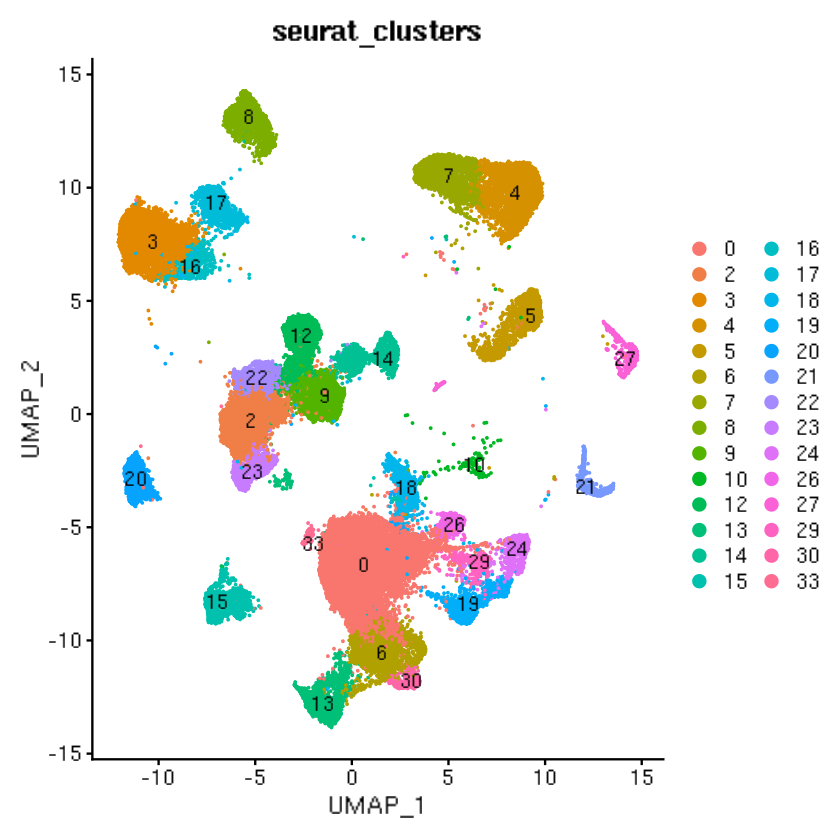

In [28]:
DimPlot(blum, reduction = "umap", group.by = "seurat_clusters", label = TRUE)

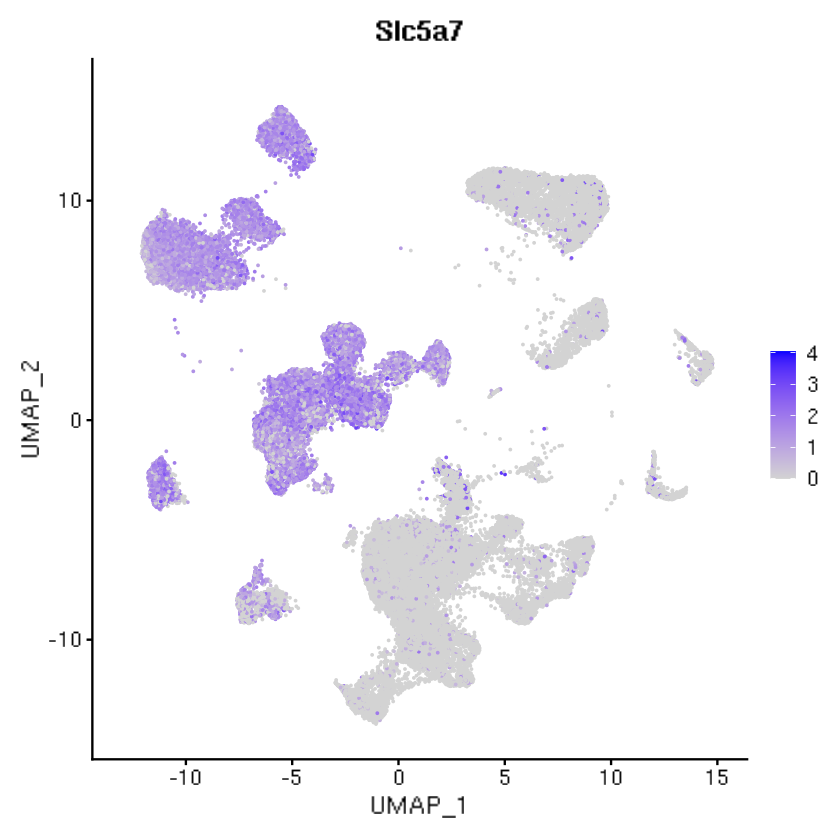

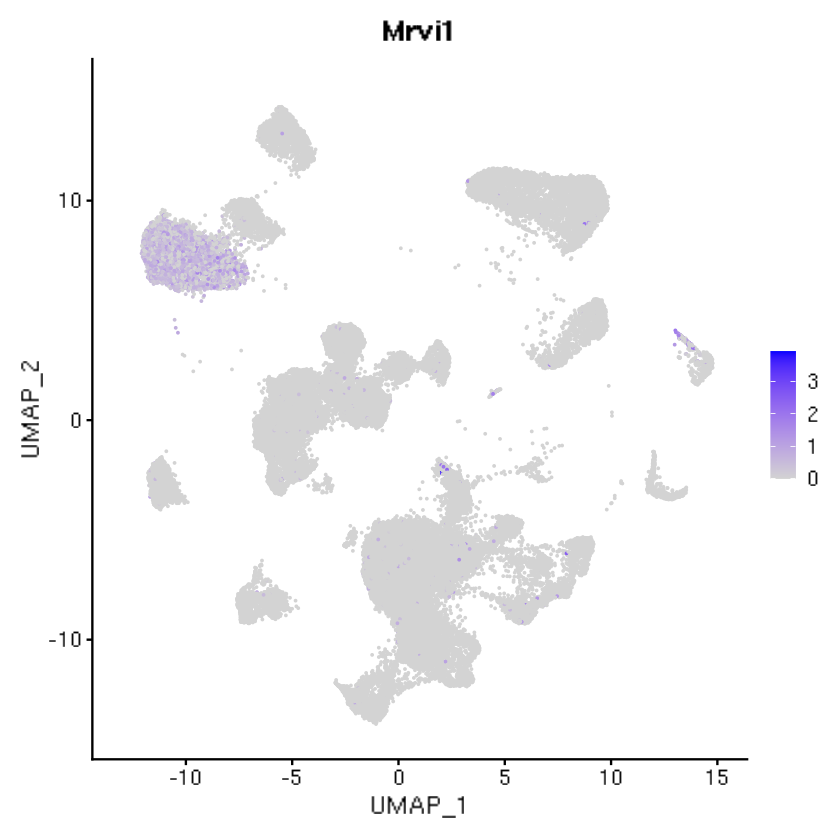

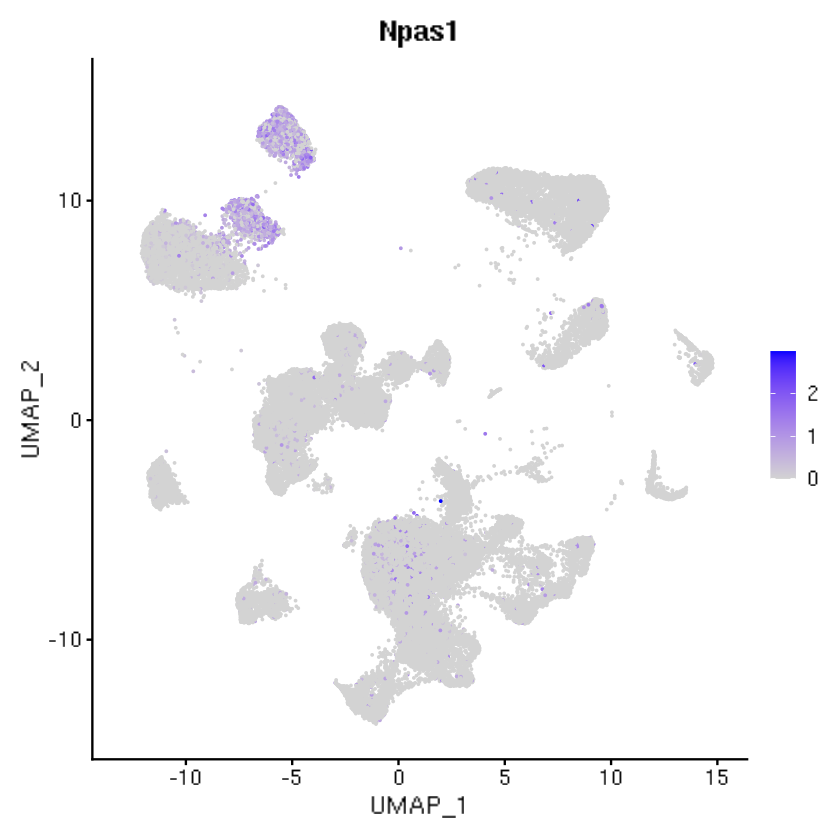

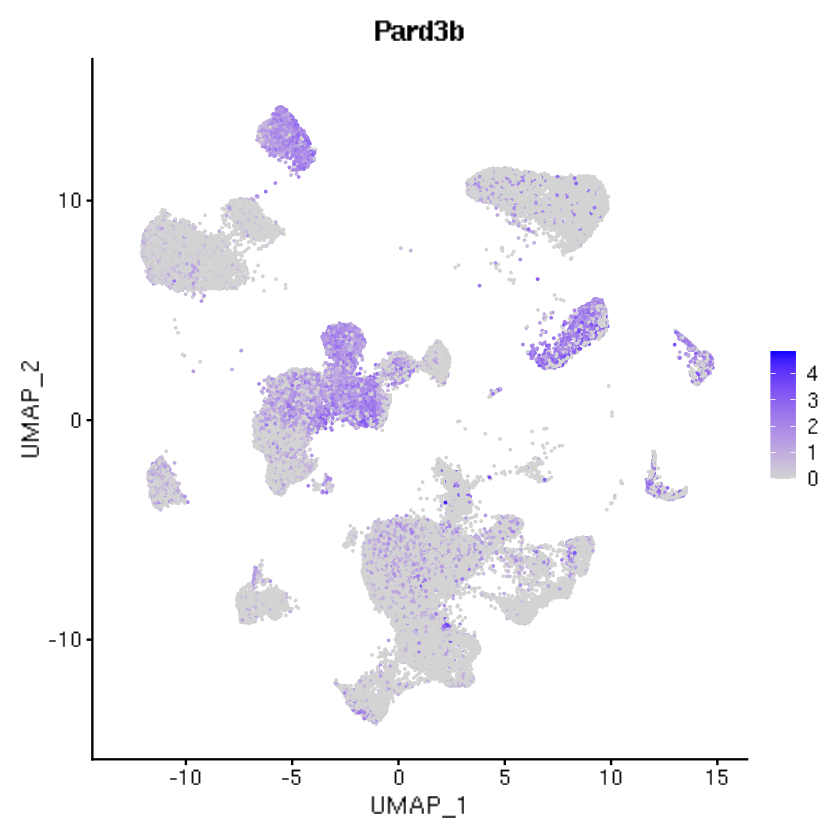

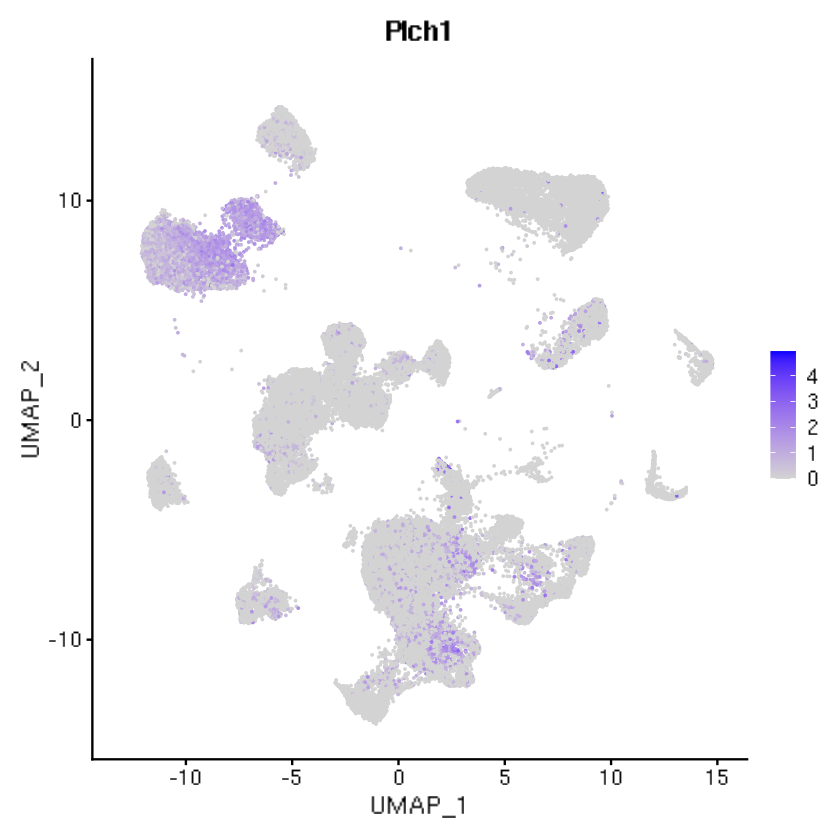

In [29]:
FeaturePlot(blum, features = c("Slc5a7"))
FeaturePlot(blum, features = c("Mrvi1"))
FeaturePlot(blum, features = c("Npas1"))
FeaturePlot(blum, features = c("Pard3b"))
FeaturePlot(blum, features = c("Plch1"))

In [30]:
# Alpha MNs: 3, 16
# Gamma MNs: 8
# Gamma* MNs: 17

In [31]:
blum_neurons <- subset(blum, cell_type %in% c("Cholinergic neurons", "Excitatory neurons", "Inhibitory neurons"))

In [32]:
blum$skeletal_motor_neuron <- ifelse(blum$seurat_clusters %in% c("3", "16", "8", "17"), yes = "Skeletal Motor Neurons", no = "Other Cells")

In [33]:
blum_neurons$skeletal_motor_neuron <- ifelse(blum_neurons$seurat_clusters %in% c("3", "16", "8", "17"), yes = "Skeletal Motor Neurons", no = "Other Neurons")

## Violin plots - genes and UMIs per nucleus

In [34]:
blum_neurons$skeletal_motor_neuron <- factor(blum_neurons$skeletal_motor_neuron, levels = c("Skeletal Motor Neurons", "Other Neurons"))

In [35]:
median_nFeature_blum <- filter(blum_neurons@meta.data, skeletal_motor_neuron == "Other Neurons") %>% {median(.$nFeature_RNA)}

In [36]:
median_nFeature_blum

[1] 3390

In [37]:
filter(blum_neurons@meta.data, skeletal_motor_neuron == "Skeletal Motor Neurons") %>% {median(.$nFeature_RNA)}

[1] 5333

In [38]:
blum_neurons$norm_nFeature_RNA = blum_neurons$nFeature_RNA/median_nFeature_blum

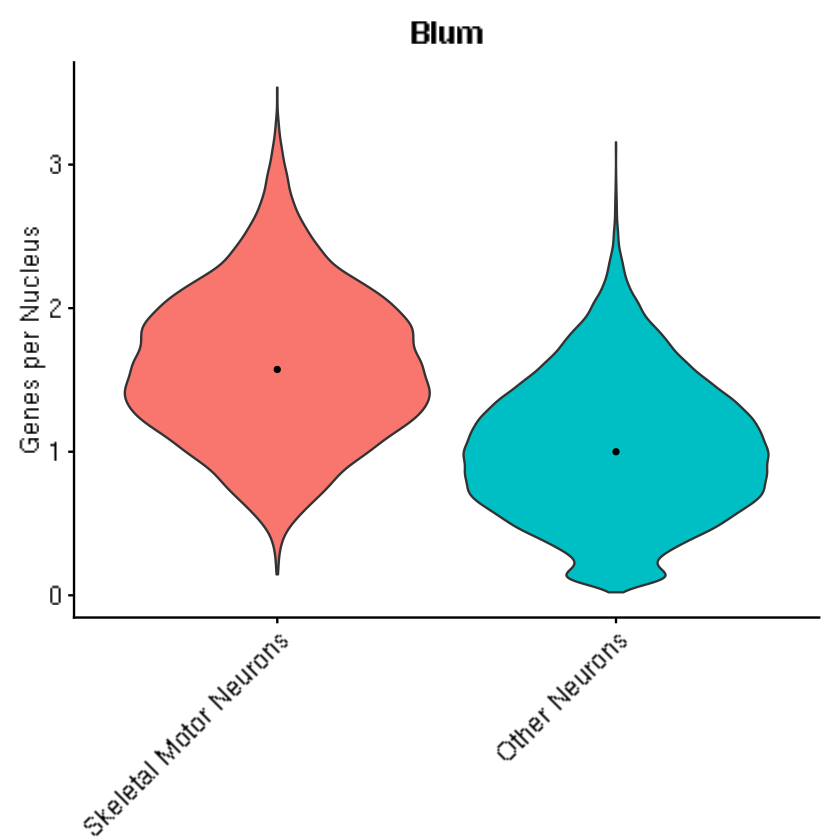

In [39]:
VlnPlot(blum_neurons, group.by = "skeletal_motor_neuron", features = "norm_nFeature_RNA", pt.size = 0) + 
  labs(title = "Blum", y = "Genes per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())

In [40]:
median_nCount_blum <- filter(blum_neurons@meta.data, skeletal_motor_neuron == "Other Neurons") %>% {median(.$nCount_RNA)}

In [41]:
median_nCount_blum

[1] 8490

In [42]:
filter(blum_neurons@meta.data, skeletal_motor_neuron == "Skeletal Motor Neurons") %>% {median(.$nCount_RNA)}

[1] 19494

In [43]:
blum_neurons$norm_nCount_RNA = blum_neurons$nCount_RNA/median_nCount_blum

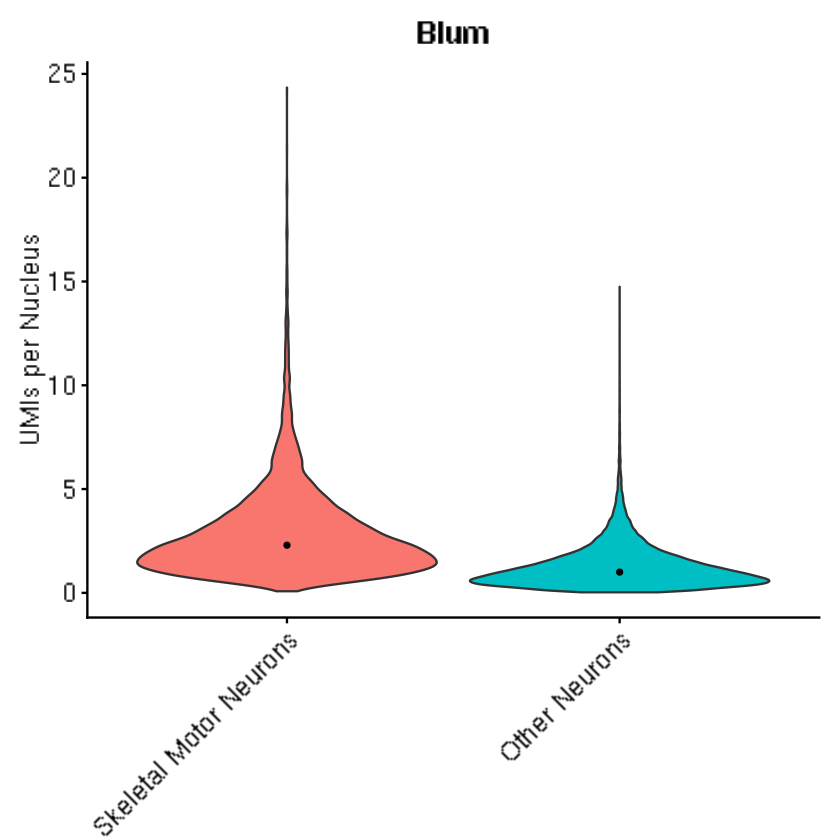

In [44]:
VlnPlot(blum_neurons, group.by = "skeletal_motor_neuron", features = "norm_nCount_RNA", pt.size = 0) + 
  labs(title = "Blum", y = "UMIs per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())

### Save objects

In [45]:
saveRDS(blum, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/blum.rds')
saveRDS(blum_neurons, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/blum_neurons.rds')

## Load Blum, Alkaslasi integrated dataset

### Alkaslasi

In [46]:
blum_alkaslasi <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/lepichon_gitler_integrated.RDS')

In [47]:
alkaslasi_chol <- subset(blum_alkaslasi, subset = group == "LePichon")

In [48]:
alkaslasi_mns <- subset(alkaslasi_chol, subset = cholinergictypes == "Skeletal Motor Neurons")

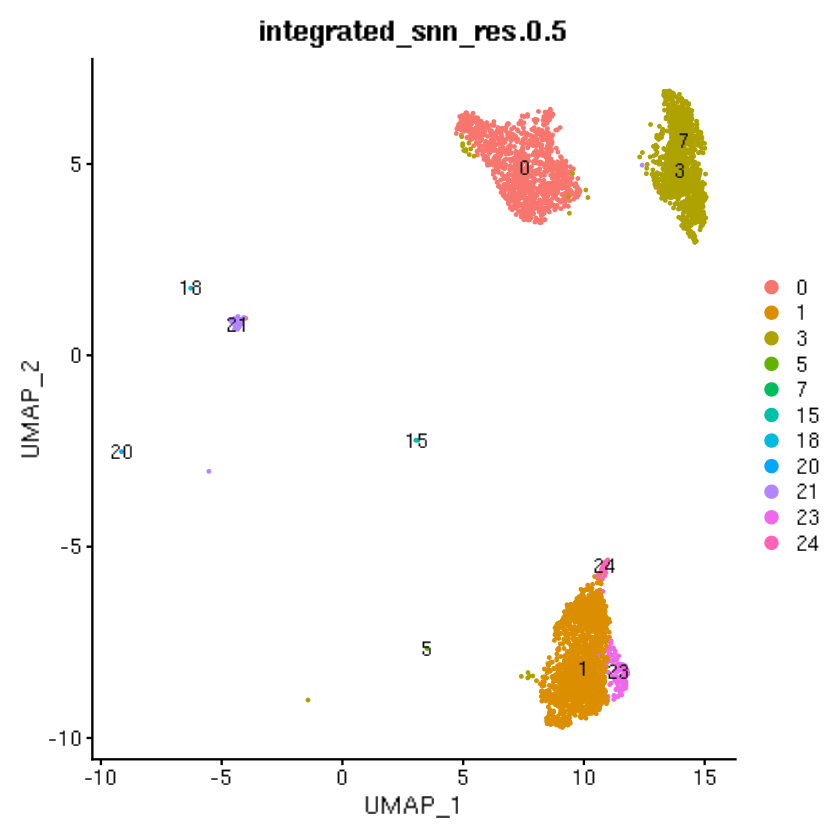

In [49]:
DimPlot(alkaslasi_mns, reduction = "umap", group.by = "integrated_snn_res.0.5", label = TRUE)

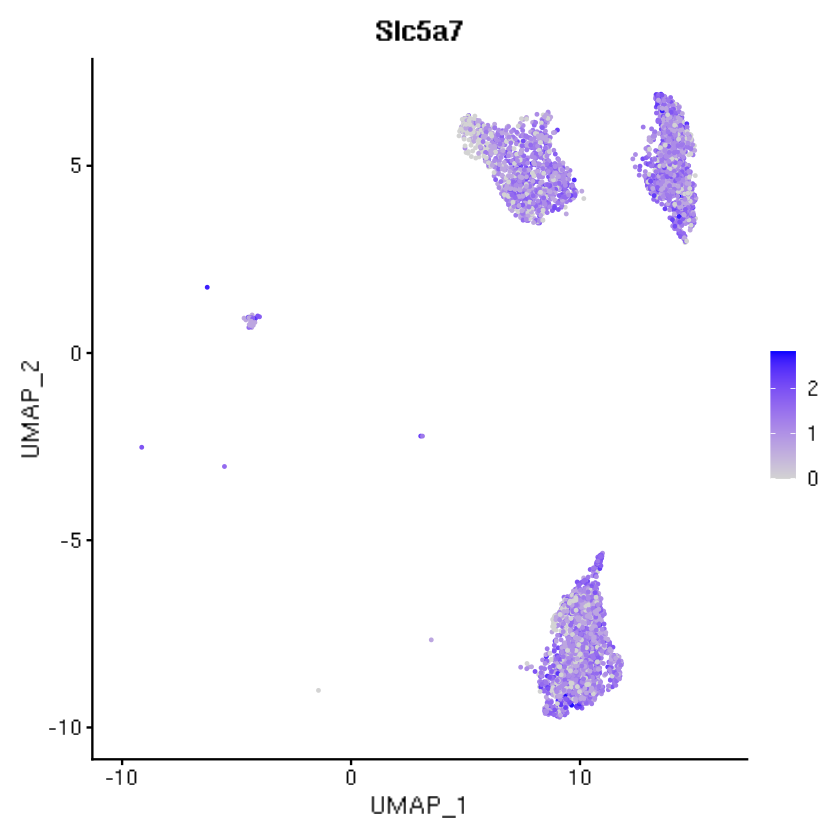

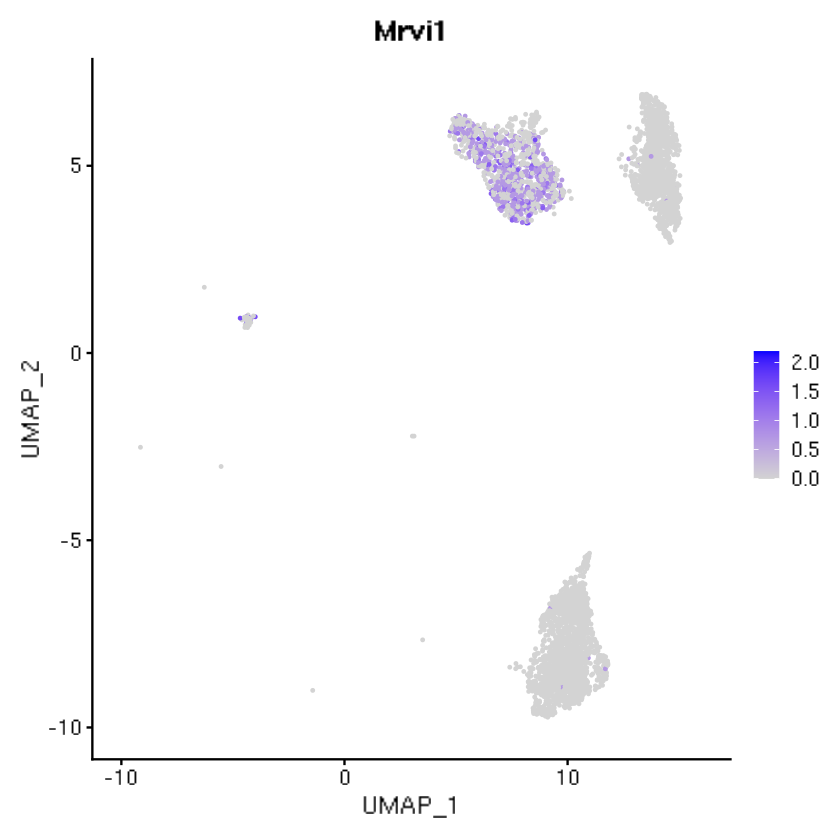

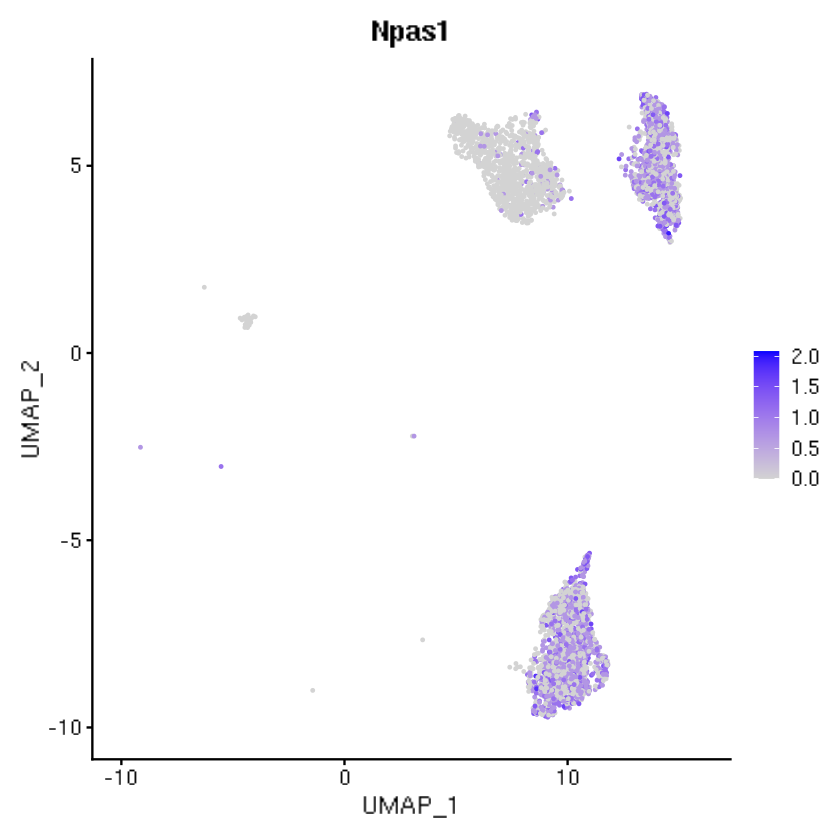

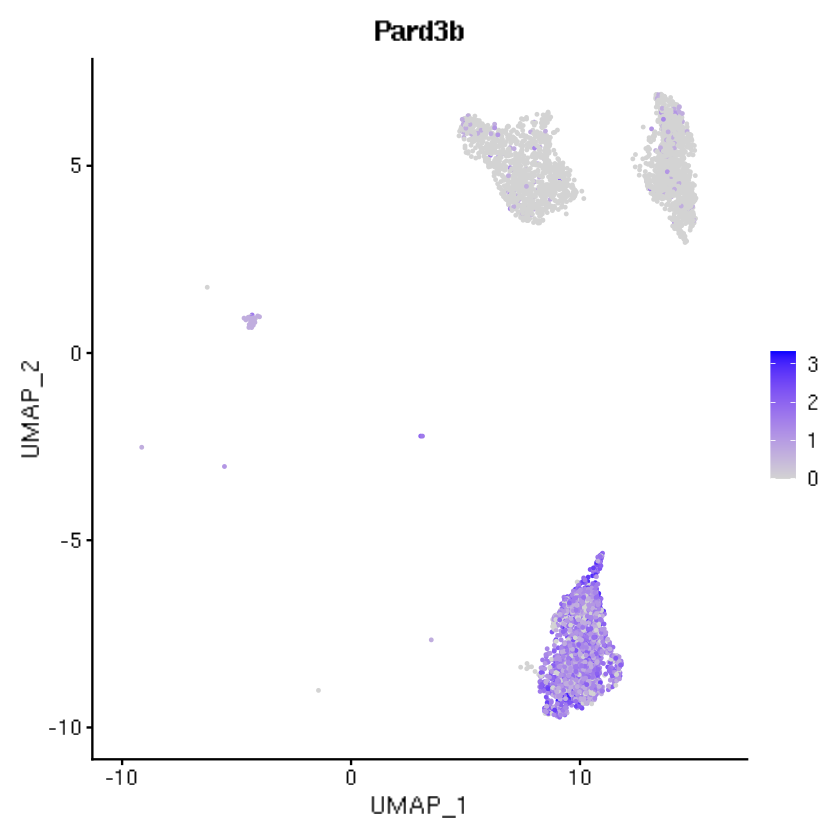

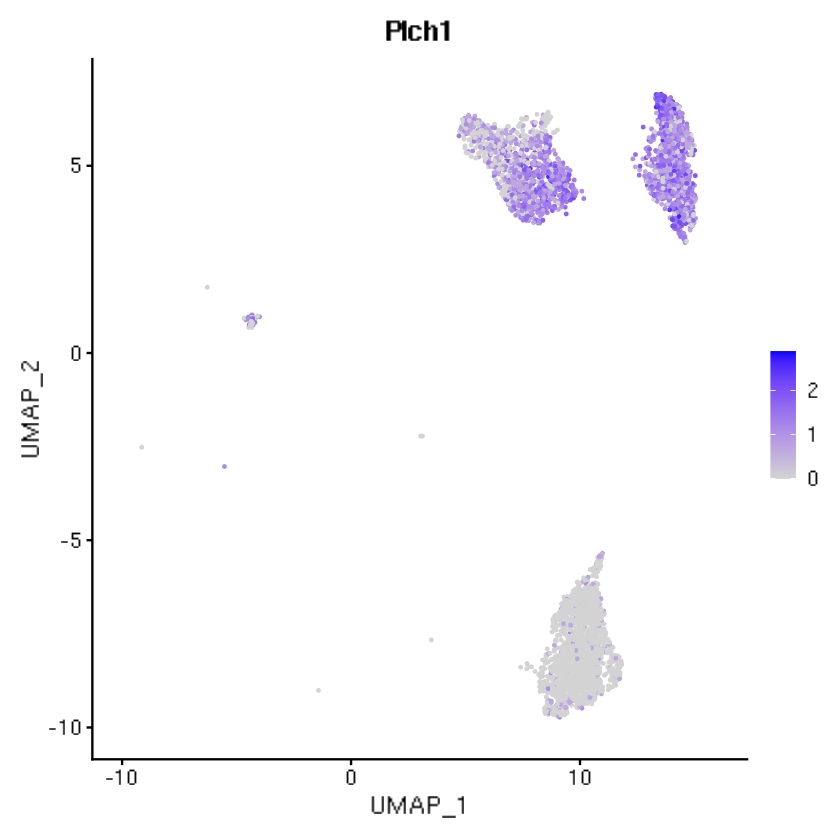

In [50]:
FeaturePlot(alkaslasi_mns, features = c("Slc5a7"))
FeaturePlot(alkaslasi_mns, features = c("Mrvi1"))
FeaturePlot(alkaslasi_mns, features = c("Npas1"))
FeaturePlot(alkaslasi_mns, features = c("Pard3b"))
FeaturePlot(alkaslasi_mns, features = c("Plch1"))

In [51]:
# Keep subclusters 0, 1, 3, 23, and 24
alkaslasi_mns <- subset(alkaslasi_mns, subset = integrated_snn_res.0.5 %in% c(0, 1, 3, 23, 24))

In [52]:
alkaslasi_mns$skeletal_subtype <- "Gamma"
alkaslasi_mns$skeletal_subtype[alkaslasi_mns$integrated_snn_res.0.5 == "0"] <- "Alpha"
alkaslasi_mns$skeletal_subtype[alkaslasi_mns$integrated_snn_res.0.5 == "3"] <- "GammaStar"

### Save object

In [53]:
saveRDS(alkaslasi_mns, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/alkaslasi_mns.rds')

### Blum

In [54]:
blum_chol <- subset(blum_alkaslasi, subset = group == "Gitler")

In [55]:
blum_mns <- subset(blum_chol, subset = cell_class == "Skeletal MNs")

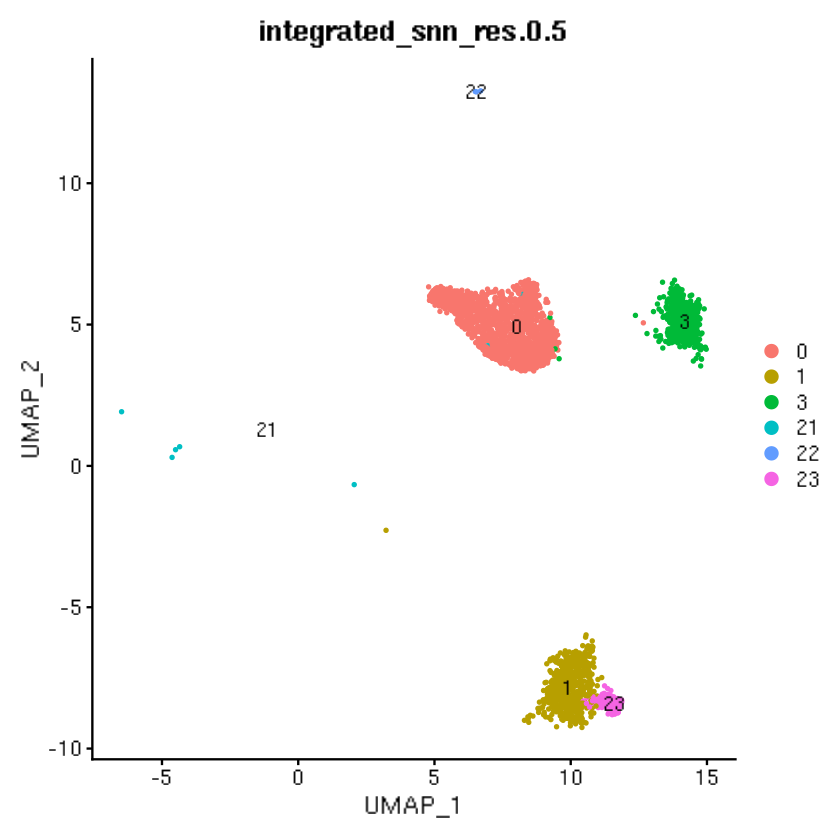

In [56]:
DimPlot(blum_mns, reduction = "umap", group.by = "integrated_snn_res.0.5", label = TRUE)

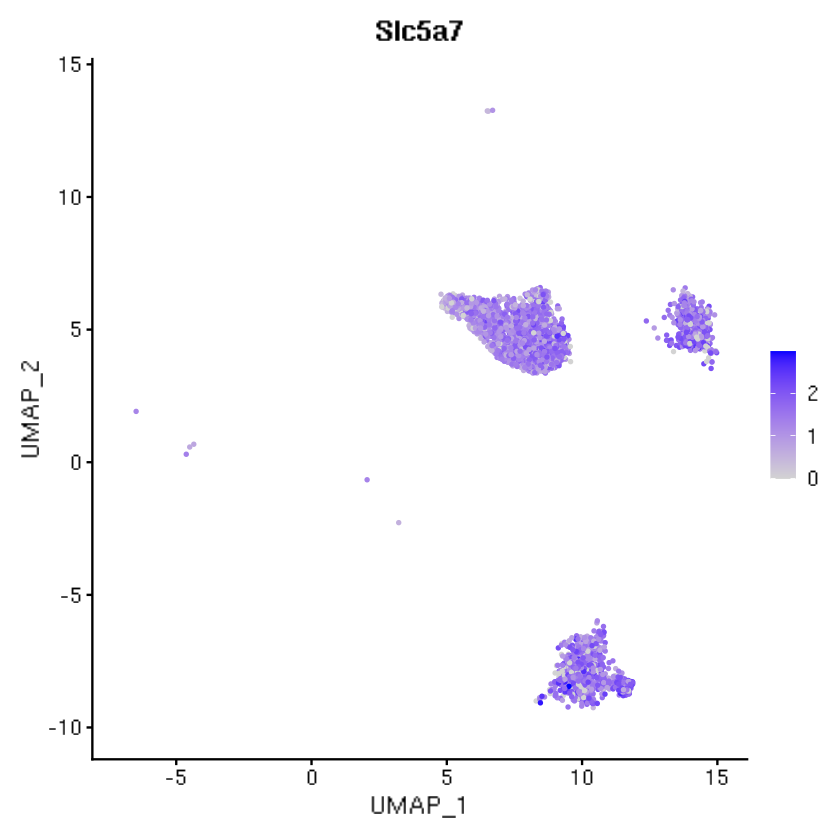

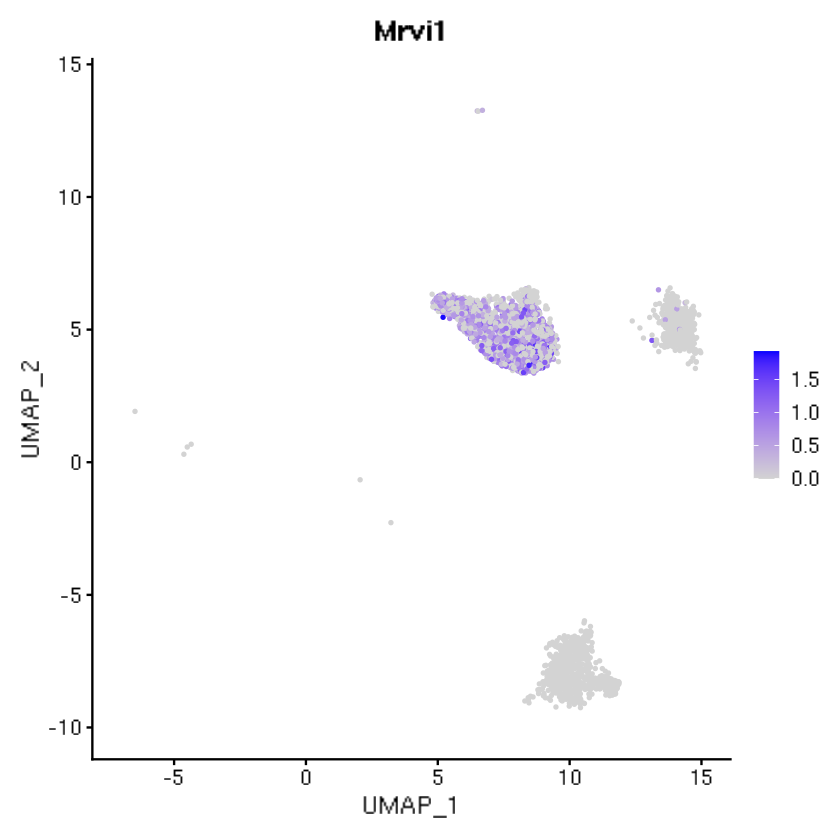

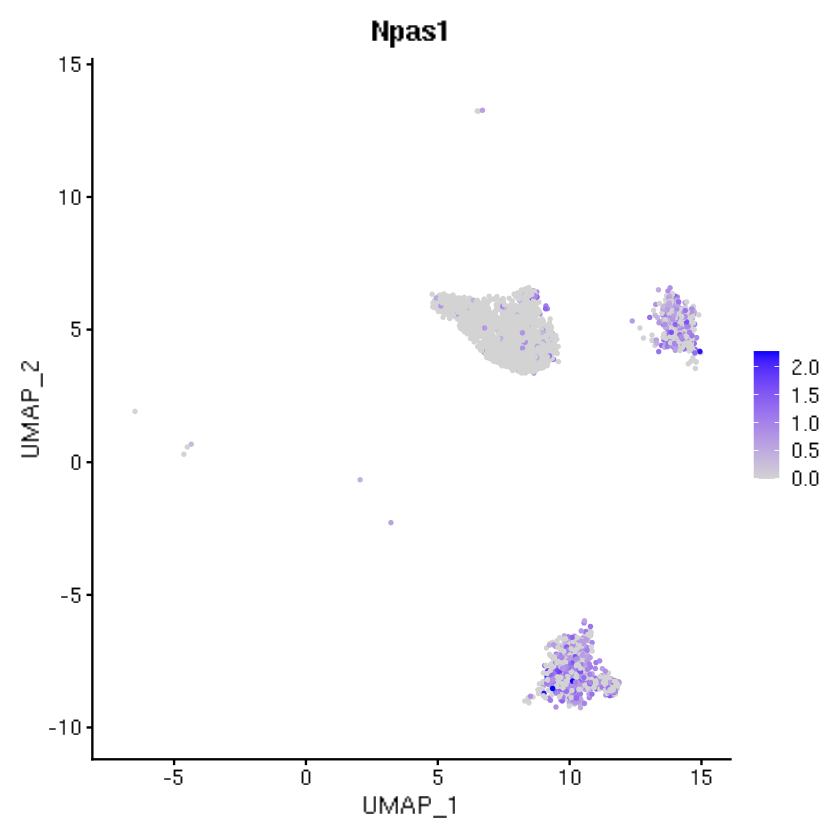

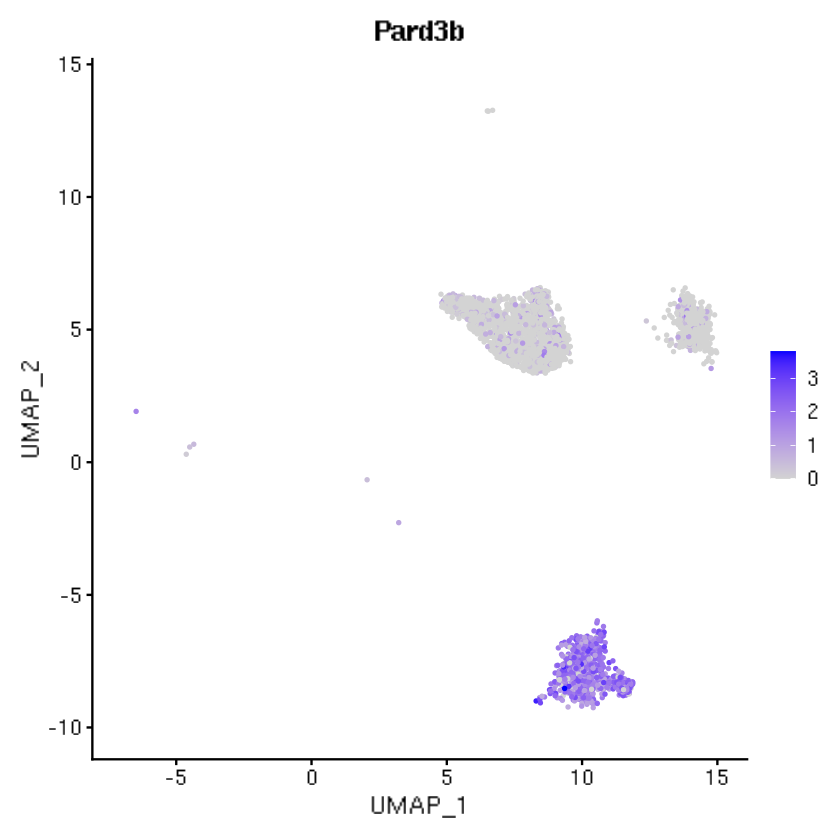

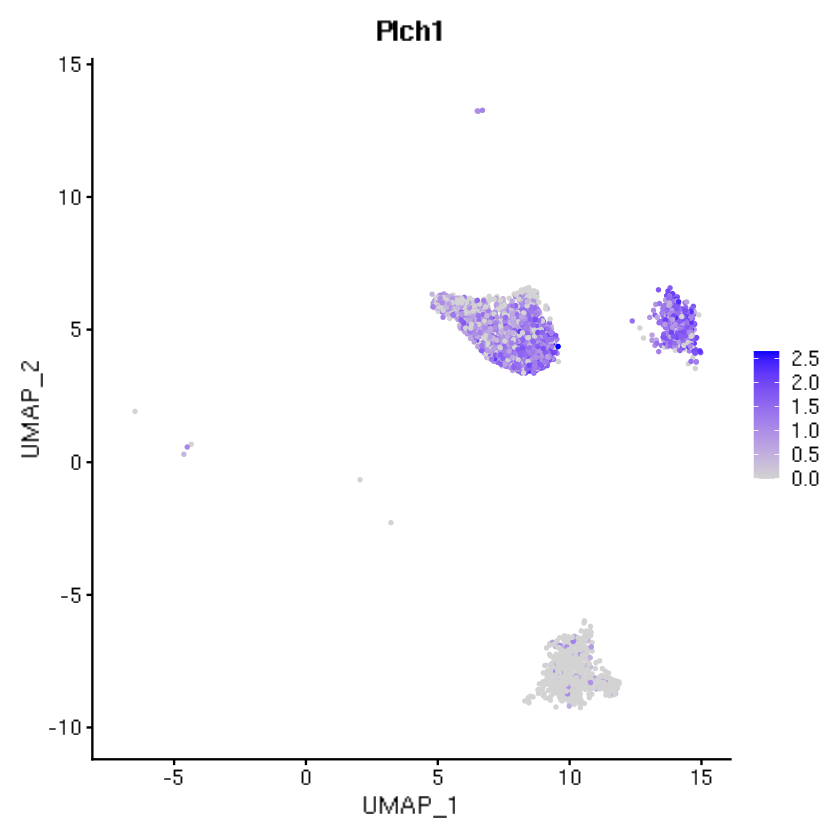

In [57]:
FeaturePlot(blum_mns, features = c("Slc5a7"))
FeaturePlot(blum_mns, features = c("Mrvi1"))
FeaturePlot(blum_mns, features = c("Npas1"))
FeaturePlot(blum_mns, features = c("Pard3b"))
FeaturePlot(blum_mns, features = c("Plch1"))

In [58]:
# Keep subclusters 0, 1, 3, and 23
blum_mns <- subset(blum_mns, subset = integrated_snn_res.0.5 %in% c(0, 1, 3, 23))

In [59]:
blum_mns$skeletal_subtype <- "Gamma"
blum_mns$skeletal_subtype[blum_mns$integrated_snn_res.0.5 == "0"] <- "Alpha"
blum_mns$skeletal_subtype[blum_mns$integrated_snn_res.0.5 == "3"] <- "GammaStar"

### Save object

In [60]:
saveRDS(blum_mns, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/blum_mns.rds')